# Variational AutoEncoders.

Yun Xing. 2023-5-18

https://keras.io/examples/generative/vae/

## Build models

In [49]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [50]:
#Create a sampling layer

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [51]:
#Build the encoder

latent_dim = 2

encoder_inputs = keras.Input(shape=(200, 200, 3))

x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 100, 100, 32  896         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_7 (Conv2D)              (None, 50, 50, 64)   18496       ['conv2d_6[0][0]']               
                                                                                            

In [52]:
# Build the decoder

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(50 * 50 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((50, 50, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_7 (Dense)             (None, 160000)            480000    
                                                                 
 reshape_3 (Reshape)         (None, 50, 50, 64)        0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 100, 100, 64)     36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 200, 200, 32)     18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 200, 200, 3)      867 

In [53]:
# Define the VAE as a Model with a custom train_step

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## 1. Train the VAE
Fit the VAE model using one of the 2 pictures, call it pic_1. Trim the picture to fit the input 200-by-200 dimensions using

In [54]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_1=mpimg.imread('pic_1.jpg')
#plt.imshow(pic_1)

pic_1 = np.expand_dims(pic_1, 0).astype("float32") / 255
pic_1 = pic_1[:,-201:-1, 0:200]

In [55]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(pic_1, epochs=30, batch_size=128)

Epoch 1/30
1/1 [==============================] - 1s 727ms/step - loss: 27725.0879 - reconstruction_loss: 27725.0859 - kl_loss: 0.0012
Epoch 2/30
1/1 [==============================] - 0s 56ms/step - loss: 27686.8867 - reconstruction_loss: 27654.1387 - kl_loss: 32.7480
Epoch 3/30
1/1 [==============================] - 0s 50ms/step - loss: 27683.9023 - reconstruction_loss: 27656.7578 - kl_loss: 27.1454
Epoch 4/30
1/1 [==============================] - 0s 49ms/step - loss: 27649.7812 - reconstruction_loss: 27642.4766 - kl_loss: 7.3039
Epoch 5/30
1/1 [==============================] - 0s 53ms/step - loss: 27553.1113 - reconstruction_loss: 27548.1836 - kl_loss: 4.9272
Epoch 6/30
1/1 [==============================] - 0s 48ms/step - loss: 27434.2578 - reconstruction_loss: 27427.3379 - kl_loss: 6.9204
Epoch 7/30
1/1 [==============================] - 0s 48ms/step - loss: 27328.1133 - reconstruction_loss: 27313.7070 - kl_loss: 14.4071
Epoch 8/30
1/1 [==============================] - 0s 49ms/

## 2. Sample the latent space. 
Explain the code in the Sampling function (copied below)

#### z_mean, z_log_var = inputs

It takes inputs as the input argument, which is a tuple containing the mean (z_mean) and log variance (z_log_var) of the latent space distribution.

#### batch = tf.shape(z_mean)[0]

#### dim = tf.shape(z_mean)[1]

Then, calculate batch size (batch) and the dimension (dim) of the z_mean tensor using TensorFlow's tf.shape function.

#### epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
Now we generate a random tensor epsilon using TensorFlow's random_normal function. The shape of epsilon is (batch, dim), which matches the shape of z_mean. This random tensor is sampled from a standard normal distribution.

#### return z_mean + tf.exp(0.5 * z_log_var) * epsilon
Then we perform the reparameterization trick, which is a technique used to sample from a differentiable distribution. It calculates the sampled latent vector z by adding the product of the exponential of half the z_log_var and epsilon to z_mean. This introduces randomness into the sampling process while ensuring that the sampling operation remains differentiable.

Overall, the Sampling layer enables the sampling of latent vectors during both the training and inference stages.

## 3. Generate Images.

In [56]:
z_mean, z_log_var, encoded_imgs = encoder.predict(pic_1)

print(z_mean, z_log_var)
print(encoded_imgs)

1/1 [==============================] - 0s 73ms/step
[[  2.1777153 -13.194418 ]] [[-6.3247395 -0.4824566]]
[[  2.2316725 -11.645425 ]]


In [57]:
decoded_imgs = decoder.predict(encoded_imgs)
print(decoded_imgs.shape)

print(pic_1.shape)  #### decoded pic and original pic have the same dimension. Good. 

1/1 [==============================] - 0s 93ms/step
(1, 200, 200, 3)
(1, 200, 200, 3)


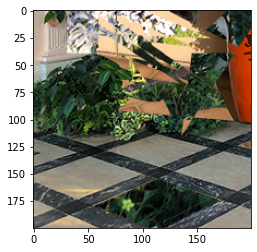

In [58]:
# pic_1 original

plt.imshow(pic_1[0])

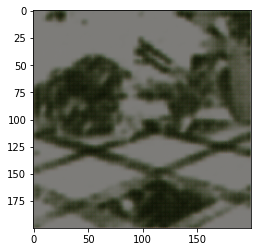

In [59]:
# pic_1 decoded

plt.imshow(decoded_imgs[0])

## 4. New input data.

In [60]:
pic_2 = mpimg.imread('pic_2.jpg')
pic_2 = np.expand_dims(pic_2, 0).astype("float32") / 255
pic_2 = pic_2[:,-201:-1, 0:200]

In [61]:
vae.fit(pic_2, epochs=30, batch_size=128)

Epoch 1/30
1/1 [==============================] - 0s 58ms/step - loss: 22845.6621 - reconstruction_loss: 22827.4180 - kl_loss: 18.2436
Epoch 2/30
1/1 [==============================] - 0s 49ms/step - loss: 22275.3887 - reconstruction_loss: 22248.3398 - kl_loss: 27.0486
Epoch 3/30
1/1 [==============================] - 0s 50ms/step - loss: 21445.6699 - reconstruction_loss: 21407.7422 - kl_loss: 37.9278
Epoch 4/30
1/1 [==============================] - 0s 53ms/step - loss: 20977.9102 - reconstruction_loss: 20925.3594 - kl_loss: 52.5506
Epoch 5/30
1/1 [==============================] - 0s 50ms/step - loss: 20705.1543 - reconstruction_loss: 20637.6797 - kl_loss: 67.4737
Epoch 6/30
1/1 [==============================] - 0s 50ms/step - loss: 20165.9258 - reconstruction_loss: 20089.9531 - kl_loss: 75.9724
Epoch 7/30
1/1 [==============================] - 0s 48ms/step - loss: 19794.8652 - reconstruction_loss: 19714.9570 - kl_loss: 79.9077
Epoch 8/30
1/1 [==============================] - 0s 52

In [62]:
z_mean, z_log_var, encoded_imgs = encoder.predict(pic_2)

print(z_mean, z_log_var)
print(encoded_imgs)


1/1 [==============================] - 0s 19ms/step
[[10.367436  -1.4432245]] [[1.7854832 3.661376 ]]
[[ 9.141039 -1.145463]]


In [63]:
decoded_imgs = decoder.predict(encoded_imgs)
print(decoded_imgs.shape)

print(pic_2.shape) 

1/1 [==============================] - 0s 35ms/step
(1, 200, 200, 3)
(1, 200, 200, 3)


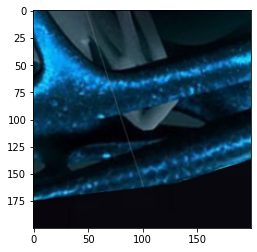

In [64]:
# pic_2 original

plt.imshow(pic_2[0])

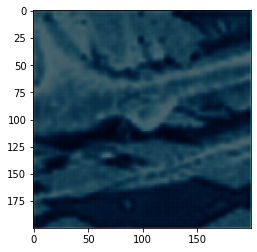

In [65]:
# pic_2 decoded

plt.imshow(decoded_imgs[0])

#### Discussions

The decoded images for pic_1 and pic_2 retain the shape and structure of original pictures. Howevere, the color is different and some details are lost. This is due to several reasons: 

1. In the encoding stage, there is variability as the model tries to capture the essential features of the input. It can result in slightly different latent representations for similar images, thus lead to differences in the decoded outputs.


2. There are constraints in the latent space. The VAE model typically uses a lower-dimensional latent space to represent the original high-dimensional input. This lower-dimensional representation imposes constraints on the information that can be captured. As a result, some color details in the original images may not be accurately captured in the latent space representation, and colors in the decoded images are different.


3. There's variability in the sampling stage. The sampling process generate new images from the latent space representations, but it introduces randomness, and different samples from the same latent vector can yield slightly different outputs. This variability will lead to variations in color and appearance between the original and decoded images.

